In [1]:
from IPython.display import display, Math, Latex

# Supervised Learning as a possible solution to RFI Flagging

***Supervised learning*** is one of the main three types of machine learning along with unsupervised learning and reinforcement learning.

Supervised learning involves modelling the relationship between input *X* and outputs *Y*, where *X* can be the features space of a given dataset and *Y* could be some label. The model is determined by showing some machine learning algorithm examples of the input *X* and the corresponding *Y* output for a function: 
$$ F: X → Y$$
so that given an unseen observation $x$, $F(x)$ can confidently predict the corresponding output $y$.

Supervised learning can be further explained through Classification or Regression, were in *classification*, the labels are discrete categories, while in *regression*, the labels are continuous quantities.

In this notebook, I will be presenting the work that I have done investigating whether or not supervised machine learning algorithms can be used to flag RFI

In [2]:
#Standard utilities
import itertools
import glob
import numpy as np
import pandas as pd
from pyrap.tables import table

# Supervised Machine learning algorithms used

### k-nearest neighbour classifier

The first algorithm to be mentioned is the k-nearest neighbour classifier, which is **non-parametric** and it is an **instant based** algorithm.

- *Non-parametric* means it makes no explicit assumptions about the functional form of F, avoiding the dangers of mismodeling the underlying distribution of the data.

- *Instance-based* learning means that our algorithm doesn’t explicitly learn a model. Instead, it chooses to memorize the training instances which are subsequently used as “knowledge” for the prediction phase. 



The K-nearest neighbor algorithm essentially boils down to forming a majority vote between the K most similar instances to a given “unseen” observation. Similarity is defined according to a distance metric between two data points. A popular choice is the Euclidean distance given by
$$d(x,x') = \sqrt{(x_{1} - x'_{1})^{2} + (x_{2} - x'_{2})^{2} +...+ (x_{n} - x'_{n})^{2} } $$

but other measures can be more suitable for a given setting and include the Manhattan, Chebyshev and Hamming distance.

More formally, given a positive integer K, an unseen observation x and a similarity metric dd, KNN classifier performs the following two steps:

- It runs through the whole dataset computing dd between $x$ and each training observation. We’ll call the K points in the training data that are closest to $x$ the set X.

- It then estimates the conditional probability for each class, that is, the fraction of points in X with that given class label. 

$$P(y = j|X = x) = \frac{1}{K} \sum_{i → X}I(y^{i} = j) $$

where $I(x)$ is the indicator function which evaluates to 1 when the argument $x$ is true and 0 otherwise.

Finally, our input $x$ gets assigned to the class with the largest probability. An alternate way of understanding KNN is by thinking about it as calculating a decision boundary.



like most machine learning algorithms, the K in KNN is a hyperparameter that you, as a designer, must pick in order to get the best possible fit for the data set. Intuitively, you can think of K as controlling the shape of the decision boundary we talked about earlier.

When K is small, we are restraining the region of a given prediction and forcing our classifier to be “more blind” to the overall distribution. A small value for K provides the most flexible fit, which will have low bias but high variance. Graphically, our decision boundary will be more jagged.

On the other hand, a higher K averages more voters in each prediction and hence is more resilient to outliers. Larger values of K will have smoother decision boundaries which means lower variance but increased bias.



### Naive Bayes Classifier

Naive bayes is a relatively simple probabilistic classfication algorithm that is well suitable for categorical data (probabilities can be compuated as simple ratios) and uses the bayes theorem together with a strong independence assumption. The basic idea behind Naive Bayes is that it assigns a probability to every category (finite outcome variable) based on the features in the data and chooses the outcome that is most likely as its prediction.

The "Naive" in the name refers to the algorithm assuming features in the data are independent conditional on the outcome category. For example in RFI classification, then given a dataset "0 (Clean), 1 (RFI)", Naive Bayes would assume "0", "1" all occur indepedently of each other (that is $P(0, 1|RFI)$ = $P(0|RFI)\times P(1|RFI)$). This conditional independence assumption is considered to be a strong assumption that often doesn't hold in practice, hence the resulting probabilities from Naive Bayes are not to be taken too seriously. However the classifications resulting from Naive Bayes can still be accurate.

In machine learning, common application of Naive Bayes are spam email classification, sentiment analysis, document categorization. Naive bayes is advantageous over other commonly used classification algorithms in its simplicity, speed, and its accuracy on small data sets. Since Naive Bayes needs to be trained on a labeled data set it considered to a supervisd learning algorithm.

Suppose we have a data set where each observation $i$ belongs to a category from the finite set $Y_{i} = \{y_{1i},y_{2i},\ldots, y_{ni}\},$ and consists of several features $X_{i} = \{x_{1i},\ldots,x_{mi}\}.$ If we could find probabilities $P(y_{1i}|X_{i}), P(y_{2i}|X_{i}), \ldots, P(y_{ni}|X_{i}),$ then we could predict the label for observation $i$ to be the one that has the highest probability.

To compute conditional probabilities, we can use the Bayes theorem from statistics which says, 
$$P(y_{ji}|X_{i}) = \frac{P(y_{ji} \text{ and } X_{i})}{P(X_{i})} = \frac{P(X_{i}|y_{ji})P(y_{ji})}{P(X_{i})},$$ 

where $j = 1, 2, \ldots, n.$ Usually $P(X_{i})$ and $P(y_{ji})$ are either well known, or can be estimated easily from the data. However $P(X_{i}|y_{ji})$ is a another conditional probability that we need to find and using Bayes rule again will not help here. This is were the "Naive" part steps in, we assume that the data features $x_{1i}, x_{2i}, \ldots, x_{mi}$ are all independent of each other conditional on knowing the class $y_{ji}.$ Statistically that means 

$$P(X_{i}|y_{ji}) = P(x_{1i}, x_{2i}, \ldots, x_{mi}|y_{ji}) = P(x_{1i}|y_{ji})P(x_{2i}|y_{ji}) \ldots P(x_{mi}|y_{ji}).$$ 

Given this result from the "Naive" assumption of conditional indepdence, we can compute 

$$P(y_{ji}|X_{i}) = \frac{P(X_{i}|y_{ji})P(y_{ji})}{P(X_{i})} = \frac{P(x_{1i}|y_{ji})P(x_{2i}|y_{ji}) \ldots P(x_{mi}|y_{ji})P(y_{ji})}{P(X_{i})}.$$

In many problems we can find $P(x_{li}|y_{ji})$ for $l = 1,\ldots,m$ by using 

$$P(x_{li}|y_{ji}) = \frac{P(x_{li} \text{ and } y_{ji})}{P(y_{ji})}.$$ 

Therefore we can find the probability of each class occuring given features in the data, $P(y_{1i}|X_{i}),P(y_{2i}|X_{i}), \ldots, P(y_{ni}|X_{i}).$ Next we can just compare all of these probabilities to each other, and pick the class that is most likely. Also note that we can omit $P(X_{i})$ in the denominator above because it is common to all the conditional class probabilities and will not effect their rankings, that is if 

\begin{eqnarray}
\frac{P(x_{1i}|y_{1i}) \ldots P(x_{mi}|y_{1i})P(y_{1i})}{P(X_{i})} &\gt& \frac{P(x_{1i}|y_{2i}) \ldots P(x_{mi}|y_{2i})P(y_{2i})}{P(X_{i})} \implies \\
P(x_{1i}|y_{1i}) \ldots P(x_{mi}|y_{1i})P(y_{1i}) &\gt& P(x_{1i}|y_{2i}) \ldots P(x_{mi}|y_{2i})P(y_{2i})
\end{eqnarray}

The Naive Bayes classifier combines this model with a decision rule, this decision rule will decide which hypothesis is most probable, in our example case this will be which class of flower is most probable.
Picking the hypothesis that is most probable is known as the maximum a posteriori or MAP decision rule. The corresponding classifier, a Bayes classifier, is the function that assigns a class label to y as follows:
Since $P(x_{1i}, ..., x_{mi}$) is constant given the input, we can use the following classification rule: 

$$P(y_{ji} \mid x_{1i}, \dots, x_{mi}) \propto P(y_{ji}) \prod_{j=1}^{m} P(x_{ji} \mid y_{ji})$$

$$\Downarrow$$$$\hat{y} = \arg\max_y P(y_{ji}) \prod_{j=1}^{n} P(X_i \mid y_{ji}),$$

and we can use Maximum A Posteriori (MAP) estimation to estimate $P(y_{ji})$ and $P(X_i | y_{ji})$; the former is then the relative frequency of class y in the training set.
There are different naive Bayes classifiers that differ mainly by the assumptions they make regarding the distribution of $P(X_i | y_{ji}$).


### Random Forest Classifier

Decision tree is a supervised learning algorithm. It works for both categorical and continuous input (features) and output (predicted) variables. Tree-based methods partition the feature space into a set of rectangles, and then fit a simple model (like a constant) in each one. They are conceptually simple yet powerful.





In [3]:
#Machine Learinging Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
#Preprocessing
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import normalize
from sklearn.cross_validation import train_test_split # Data splitting

/data/olorato/mywork/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
#Performance Measures
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score,matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix


#Feature Selection
from skfeature.function.similarity_based import fisher_score
from skfeature.function.similarity_based import reliefF
from skfeature.function.statistical_based import CFS


#plotting
import seaborn as sns
import matplotlib as mpl
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
sns.set_context('paper',font_scale=2.0)
sns.set_style("whitegrid")
palette = sns.plt.cm.gray_r
# set masked values to plot red
palette.set_bad('r', 1.0)

In [6]:
def roc_plot(classifiers,subplot,model_names):
    #c = ['r','g','b']
    if subplot == True:
        num = len(classifiers)
        sns.plt.figure()
        for i in range(num):
            sns.plt.subplot(1,num,i+1)
            clf = classifiers[i]
            y_roy_fpr, y_roy_tpr, y_roy_thresholds = roc_curve(y_test0, clf[:,1])
            sns.plt.plot(y_roy_fpr, y_roy_tpr,label=model_names[i]+' AUC = %0.2f'% auc(y_roy_fpr, y_roy_tpr))
            sns.plt.legend(loc='lower right')
            sns.plt.plot([0,1],[0,1],'r--')
            sns.plt.xlim([-0.1,1.2])
            sns.plt.ylim([-0.1,1.2])
            sns.plt.ylabel('True Positive Rate')
            sns.plt.xlabel('False Positive Rate')
    if subplot == False:
        num = len(classifiers)
        sns.plt.figure()
        for i in range(num):
            clf = classifiers[i]
            y_roy_fpr, y_roy_tpr, y_roy_thresholds = roc_curve(y_test0, clf[:,1])
            sns.plt.plot(y_roy_fpr, y_roy_tpr,label=model_names[i]+' AUC = %0.2f'% auc(y_roy_fpr, y_roy_tpr))
            sns.plt.legend(loc='lower right')
            sns.plt.plot([0,1],[0,1],'r--')
            sns.plt.xlim([-0.1,1.2])
            sns.plt.ylim([-0.1,1.2])
            sns.plt.ylabel('True Positive Rate')
            sns.plt.xlabel('False Positive Rate')
    return

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=sns.plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #sns.plt.title(title)
    #sns.plt.colorbar()
    tick_marks = np.arange(len(classes))
    sns.plt.xticks(tick_marks, classes, rotation=45)
    sns.plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            sns.plt.text(j, i, round(cm[i, j],2),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            sns.plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    sns.plt.tight_layout()
    sns.plt.grid(False)
    sns.plt.ylabel('True label')
    sns.plt.xlabel('Predicted label')

In [8]:
def evaluate(model,modelname):
    print('====================================================')
    print('Classification Report for %s'%modelname)
    print('====================================================')
    print(classification_report(y_test0,model,target_names=['Not RFI','RFI']))

    print('\n The model is %f accurate' %(accuracy_score(y_test0,model)*100))
    print('====================================================\n\n')

In [9]:
def report(results,num, n_top=3):
    #n_top = len(results['rank_test_score']) -1
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## retriving all of the datasets

In [10]:
data_files = shuffle(glob.glob("HH13*pks1613*csv"),random_state=3)
print data_files

['HH1324619115_pks1613-586.1826.ms_all_data_baseline3and5.csv', 'HH1333134985_pks1613-586.1822.ms_all_data_baseline0and5.csv', 'HH1333305511_pks1613-586.1822.ms_all_data_baseline2and4.csv', 'HH1333134985_pks1613-586.1822.ms_all_data_baseline4and5.csv', 'HH1333305511_pks1613-586.1822.ms_all_data_baseline4and5.csv', 'HH1324619115_pks1613-586.1826.ms_all_data_baseline2and3.csv', 'HH1333305511_pks1613-586.1822.ms_all_data_baseline5and6.csv', 'HH1324619115_pks1613-586.1826.ms_all_data_baseline1and4.csv', 'HH1333305511_pks1613-586.1822.ms_all_data_baseline3and6.csv', 'HH1333134985_pks1613-586.1822.ms_all_data_baseline5and6.csv', 'HH1333134985_pks1613-586.1822.ms_all_data_baseline0and4.csv', 'HH1324619115_pks1613-586.1826.ms_all_data_baseline1and3.csv', 'HH1333134985_pks1613-586.1822.ms_all_data_baseline1and3.csv', 'HH1333134985_pks1613-586.1822.ms_all_data_baseline3and5.csv', 'HH1333134985_pks1613-586.1822.ms_all_data_baseline0and2.csv', 'HH1333305511_pks1613-586.1822.ms_all_data_baseline1an

In [11]:
#names of the features
names = ["d_p","tC_mean","tp_mean",'t_skew','t_kurtosis','t_cumsumx','t_sumvalues'
         ,'t_slope','t_per25','t_per75','t_var',"fC_mean","fp_mean",'f_skew'
         ,'f_kurtosis','f_cumsumx','f_sumvalues','f_slope','f_per25','f_per75','f_var']
target_names = ['Not RFI','RFI']
#getting feature pairs for plotting
pairs = list(itertools.combinations(names,2))
len(pairs)

210

In [ ]:
#selecting datasets to use for Training
data_names =[]
datasets = []
for filename in shuffle(data_files[0:4],random_state=4):
    data = pd.DataFrame.from_csv(filename)
    if len(np.where(data["rfi"].values == 1)[0])/float(len(data["rfi"])) < 0.4:       
        datasets.append(data)
        print filename
        data_names.append(filename)
    del data
X0 = pd.concat(datasets, ignore_index=True)
del datasets

In [ ]:
for i in data_names:    
    testVV = pd.DataFrame.from_csv(i)
    image = np.reshape(testVV['d_p'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F' )
    org_flags = np.reshape(testVV['rfi'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F')

    sns.plt.figure(figsize=(20,20))
    sns.plt.subplot(2,1,1)
    sns.plt.imshow(image,cmap=palette,aspect ='auto')
    sns.plt.grid(False)
    sns.plt.colorbar()
    sns.plt.xlabel("Channels")
    sns.plt.ylabel("No flags")
    sns.plt.xticks([])
    sns.plt.yticks([])
    ns.plt.subplot(2,1,2)
    sns.plt.imshow(np.ma.array(image,mask=org_flags),cmap=palette,aspect ='auto')
    sns.plt.grid(False)
    sns.plt.colorbar()
    sns.plt.xlabel("Channels")
    sns.plt.ylabel("No flags")
    sns.plt.xticks([])
    sns.plt.yticks([])
    sns.plt.show()


In [13]:
X0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4780720 entries, 0 to 4780719
Data columns (total 25 columns):
ant1           int64
ant2           int64
d_p            float64
fC_mean        float64
f_cumsumx      float64
f_kurtosis     float64
f_per25        float64
f_per75        float64
f_skew         float64
f_slope        float64
f_sumvalues    float64
f_var          float64
fp_mean        float64
frequency      int64
rfi            int64
tC_mean        float64
t_cumsumx      float64
t_kurtosis     float64
t_per25        float64
t_per75        float64
t_skew         float64
t_slope        float64
t_sumvalues    float64
t_var          float64
tp_mean        float64
dtypes: float64(21), int64(4)
memory usage: 911.9 MB


In [14]:
X0.describe()

,ant1,ant2,d_p,fC_mean,f_cumsumx,f_kurtosis,f_per25,f_per75,f_skew,f_slope,...,tC_mean,t_cumsumx,t_kurtosis,t_per25,t_per75,t_skew,t_slope,t_sumvalues,t_var,tp_mean
count,4.780720e+06,4.780720e+06,4.780720e+06,4.780720e+06,4.780720e+06,4.780720e+06,4.780720e+06,4.780720e+06,4.780720e+06,4.780720e+06,...,4.780720e+06,4.780720e+06,4.780720e+06,4.780720e+06,4.780720e+06,4.780720e+06,4.780720e+06,4.780720e+06,4.780720e+06,4.780720e+06
mean,2.738198e+00,4.902609e+00,1.381622e-01,1.392435e-01,1.415207e+00,-5.716055e-01,1.156890e-01,1.583056e-01,3.979399e-02,8.008098e-01,...,1.381622e-01,1.243462e+00,-6.069822e-01,1.173515e-01,1.587447e-01,1.724170e-02,4.655557e-02,1.243462e+00,1.223587e-03,1.381624e-01
std,9.224442e-01,2.964897e-01,5.523886e-02,1.868999e-02,2.783381e+00,8.337005e-01,3.068687e-02,3.851235e-02,6.241279e-01,5.731780e+01,...,1.831876e-02,3.846418e-01,7.317185e-01,4.207731e-02,4.692969e-02,5.889413e-01,3.212565e+01,3.846418e-01,7.409854e-03,4.273797e-02
min,0.000000e+00,4.000000e+00,2.263376e-04,1.038014e-01,4.462896e-03,-1.935228e+00,1.626155e-04,5.667341e-04,-2.424311e+00,-8.746804e+03,...,1.069716e-01,2.652427e-01,-1.948098e+00,9.994046e-03,2.593289e-02,-2.473198e+00,-3.983188e+02,2.652427e-01,1.043001e-05,2.947141e-02
25%,3.000000e+00,5.000000e+00,1.080548e-01,1.299267e-01,1.087355e+00,-1.129421e+00,9.826906e-02,1.393975e-01,-3.586811e-01,-2.204286e+01,...,1.324123e-01,1.082117e+00,-1.130347e+00,9.861071e-02,1.388670e-01,-3.648565e-01,-2.153634e+01,1.082117e+00,7.076836e-04,1.202352e-01
50%,3.000000e+00,5.000000e+00,1.352949e-01,1.366787e-01,1.214286e+00,-7.642592e-01,1.139218e-01,1.553714e-01,2.266038e-02,6.205980e-02,...,1.374600e-01,1.213233e+00,-7.675896e-01,1.145021e-01,1.551479e-01,1.560567e-02,2.254168e-02,1.213233e+00,1.037811e-03,1.348037e-01
75%,3.000000e+00,5.000000e+00,1.635323e-01,1.459140e-01,1.353404e+00,-2.443079e-01,1.302270e-01,1.726069e-01,4.112275e-01,2.248581e+01,...,1.436152e-01,1.354123e+00,-2.598701e-01,1.311999e-01,1.726245e-01,3.972020e-01,2.162409e+01,1.354123e+00,1.468026e-03,1.504581e-01
max,4.000000e+00,5.000000e+00,4.857348e+00,2.955002e-01,4.905352e+01,4.125003e+00,6.458650e-01,2.439027e+00,2.474874e+00,8.450930e+03,...,1.076279e+00,3.730111e+01,4.121360e+00,3.972086e+00,4.640138e+00,2.473575e+00,4.188197e+02,3.730111e+01,4.600406e+00,4.144568e+00


In [15]:
X0.head()

,ant1,ant2,d_p,fC_mean,f_cumsumx,f_kurtosis,f_per25,f_per75,f_skew,f_slope,...,tC_mean,t_cumsumx,t_kurtosis,t_per25,t_per75,t_skew,t_slope,t_sumvalues,t_var,tp_mean
0,3,5,0.096060,0.124674,1.138095,-0.939905,0.104884,0.142108,-0.390493,55.458171,...,0.10754,0.968296,-1.20361,0.095667,0.129695,0.282033,53.464233,0.968296,0.000475,0.107588
1,3,5,0.108637,0.123508,1.140816,-0.291767,0.108637,0.150344,-0.456015,-12.900976,...,0.10754,0.968296,-1.20361,0.095667,0.129695,0.282033,53.464233,0.968296,0.000475,0.107588
2,3,5,0.096557,0.122613,1.122937,-1.489285,0.096751,0.166870,0.397149,-23.273783,...,0.10754,0.968296,-1.20361,0.095667,0.129695,0.282033,53.464233,0.968296,0.000475,0.107588
3,3,5,0.074223,0.126031,1.020696,-1.347825,0.074223,0.134259,-0.163223,57.596100,...,0.10754,0.968296,-1.20361,0.095667,0.129695,0.282033,53.464233,0.968296,0.000475,0.107588
4,3,5,0.142154,0.123002,1.031142,-1.098979,0.093705,0.141704,-0.233084,23.178363,...,0.10754,0.968296,-1.20361,0.095667,0.129695,0.282033,53.464233,0.968296,0.000475,0.107588


In [16]:
print("Following is a breakup of RFI Class. 1 means RFI, 0 means not RFI(clean data).")
print(X0['rfi'].value_counts())

Following is a breakup of RFI Class. 1 means RFI, 0 means not RFI(clean data).
0    4757586
1      23134
Name: rfi, dtype: int64


# Exploratory Data Analysis
###  Histograms of various features by RFI class

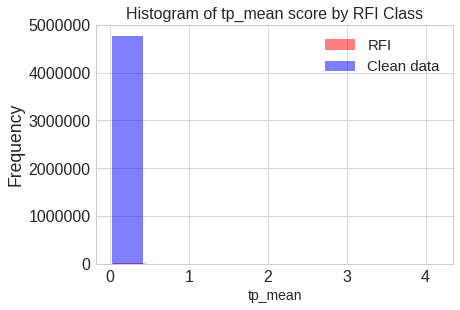

In [17]:
sns.plt.figure()
X0[X0['rfi']==1][names[2]].plot.hist(alpha=0.5,color='red', label='RFI')
X0[X0['rfi']==0][names[2]].plot.hist(alpha=0.5, color='blue', label='Clean data')

sns.plt.legend(fontsize=15)
sns.plt.title ("Histogram of "+str(names[2])+" score by RFI Class", fontsize=16)
sns.plt.xlabel(names[2], fontsize=14)
sns.plt.show()

from the image above one can see that the clean data seem to be concentrated around some small region in the feature space. When it comes to RFI the region in which RFI lies is more spread out around and away from the region of clean data

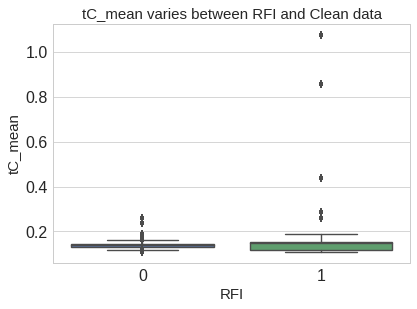

In [18]:
sns.plt.figure()
sns.boxplot(x=X0['rfi'],y=X0[names[1]])
sns.plt.title(str(names[1])+" varies between RFI and Clean data", fontsize=15)
sns.plt.xlabel("RFI",fontsize=15)
sns.plt.ylabel(str(names[1]),fontsize=15)
sns.plt.show()

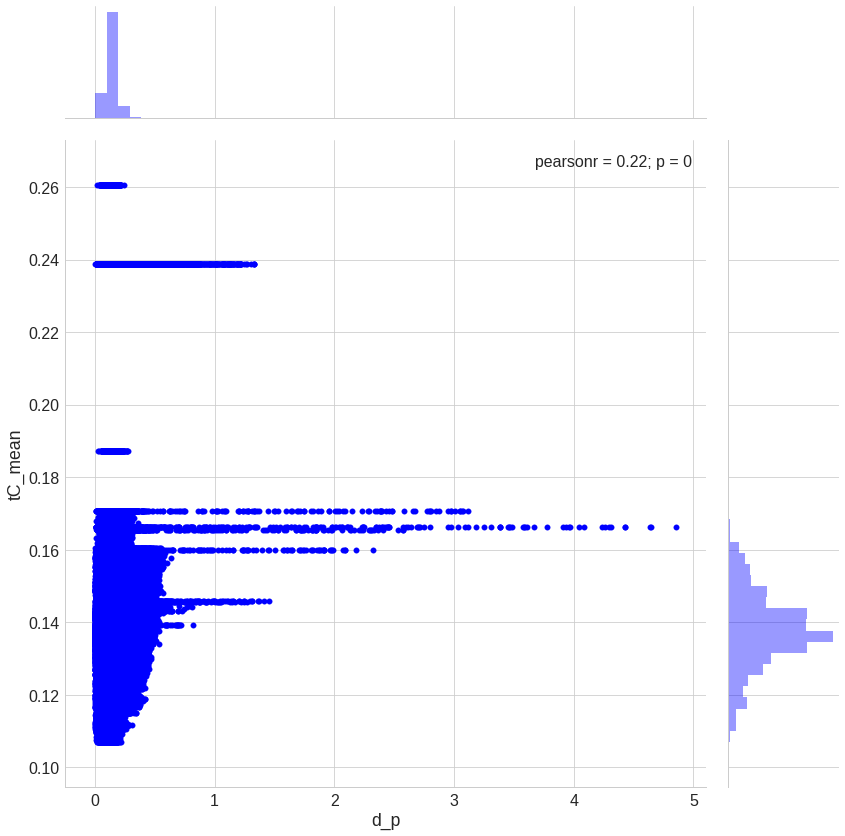

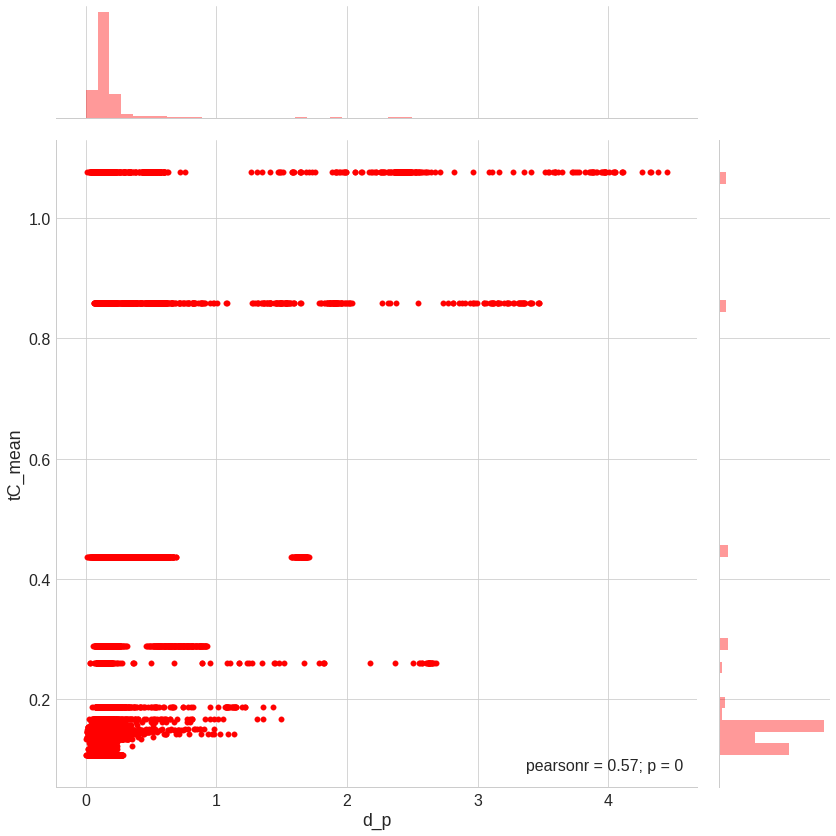

In [19]:
sns.plt.figure()
X1 = X0[X0.rfi==0]
sns.jointplot(x=names[0],y=names[1],data=X1, color='blue', size=12)
X1 = X0[X0.rfi==1]
sns.jointplot(x=names[0],y=names[1],data=X1, color='red', size=12)
del X1
sns.plt.show()

In [20]:
for i in range(10):
    X0= shuffle(X0,random_state=2458)
HH_X0_not = X0[X0["rfi"]==0]
HH_X0_is = X0[X0["rfi"]==1]
X0 = pd.concat([HH_X0_not[:int(len(HH_X0_is)*4.0)],HH_X0_is[:len(HH_X0_is)]], ignore_index=True)
del HH_X0_not
del HH_X0_is
X0 = shuffle(X0.drop_duplicates())
print len(X0),len(np.unique(X0["d_p"]))

115670 115132


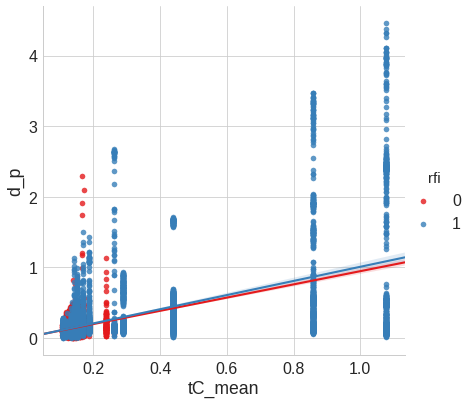

In [21]:
sns.plt.figure(figsize=(14,7))
sns.lmplot(y=names[0],x=names[1],data=X0,hue='rfi',palette='Set1',size=6)
sns.plt.show()

# Overview of entire feature space

In [22]:
#sns.plt.figure()
#sns.set_style("whitegrid")
#sns.pairplot(shuffle(X0)[:], size=3 ,diag_kind="kde",hue="rfi",palette=["b","r"],
#             vars=np.unique(list(itertools.combinations(names,2))[:]),markers=["s","^"],
#             plot_kws=dict(s=100, edgecolor="k", linewidth=1,alpha=0.8,),
#             diag_kws=dict(shade=True))
#sns.plt.show()

# Train Test Split

In [23]:
x_train0, x_test0, y_train0, y_test0 = train_test_split(X0[names]
                                        ,X0['rfi'], test_size=0.30
                                        ,random_state=6)

# KNeighborsClassifier

In [24]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train0,y_train0)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [25]:
pred = knn.predict(x_test0)

[[23169  4610]
 [ 5222  1700]]


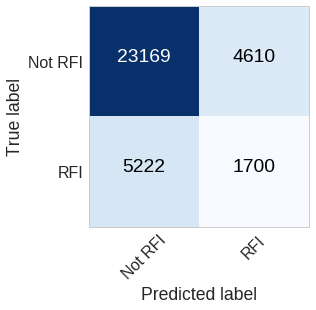

('Misclassification error rate:', 0.283)
('matthews_corrcoef: ', 0.08250991007482894)


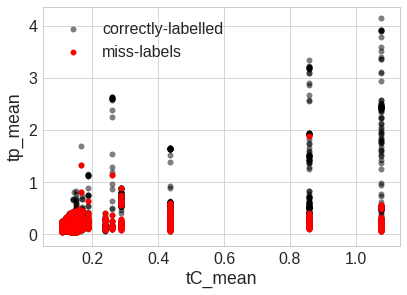

In [26]:
conf_mat=confusion_matrix(y_test0,pred)
print conf_mat
plot_confusion_matrix(conf_mat, classes=target_names,normalize=False)
sns.plt.show()
print("Misclassification error rate:",round(np.mean(pred!=y_test0),3))
print("matthews_corrcoef: ",matthews_corrcoef(y_test0,pred,))
sns.plt.figure()
sns.plt.scatter(x_test0[names[1]],x_test0[names[2]],c='k',alpha=0.5,label='correctly-labelled')
sns.plt.scatter(x_test0[names[1]].values[np.where(y_test0!=pred)[0]],x_test0[names[2]].values[np.where(y_test0!=pred)[0]],c='r',label='miss-labels')
sns.plt.xlabel(names[1])
sns.plt.ylabel(names[2])
sns.plt.legend(loc='best')
sns.plt.show()

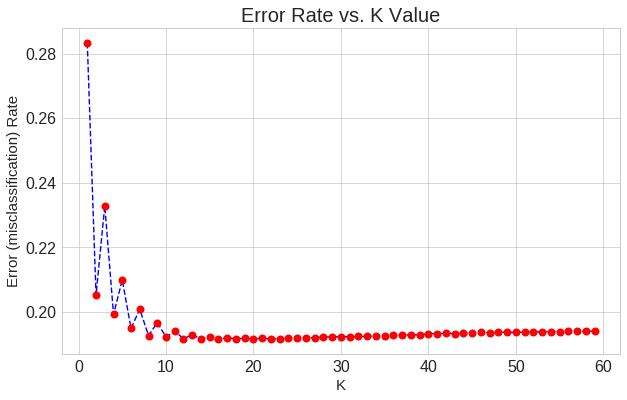

In [27]:
error_rate = []

# Will take some time
for i in range(1,60):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train0,y_train0)
    pred_i = knn.predict(x_test0)
    error_rate.append(np.mean(pred_i != y_test0))

sns.plt.figure(figsize=(10,6))
sns.plt.plot(range(1,60),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)
sns.plt.title('Error Rate vs. K Value', fontsize=20)
sns.plt.xlabel('K',fontsize=15)
sns.plt.ylabel('Error (misclassification) Rate',fontsize=15)
sns.plt.show()

# Training a Decision Tree Model

In [28]:
dtree = DecisionTreeClassifier(criterion='gini',max_depth=None)
dtree.fit(x_train0,y_train0)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Predictions and Evaluation of Decision Tree
Create predictions from the test set and create a classification report and a confusion matrix.

In [29]:
pred = dtree.predict(x_test0)

[[27624   155]
 [  128  6794]]


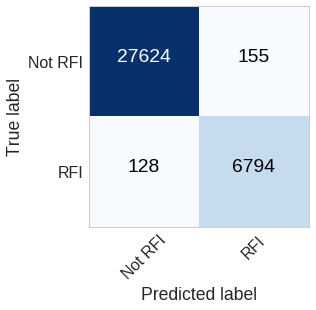

('Misclassification error rate:', 0.008)
('matthews_corrcoef: ', 0.97450437707816095)


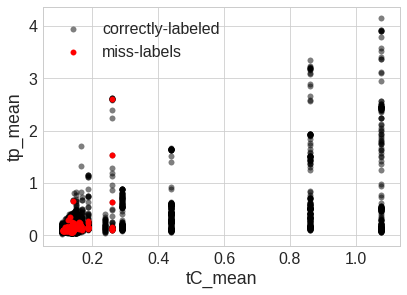

In [30]:
conf_mat=confusion_matrix(y_test0,pred)
print conf_mat
plot_confusion_matrix(conf_mat, classes=target_names,normalize=False)
sns.plt.show()
print("Misclassification error rate:",round(np.mean(pred!=y_test0),3))
print("matthews_corrcoef: ",matthews_corrcoef(y_test0,pred))
sns.plt.figure()
sns.plt.scatter(x_test0[names[1]],x_test0[names[2]],c='k',alpha=0.5,label='correctly-labeled')
sns.plt.scatter(x_test0[names[1]].values[np.where(y_test0!=pred)[0]],x_test0[names[2]].values[np.where(y_test0!=pred)[0]],c='r',label='miss-labels')
sns.plt.xlabel(names[1])
sns.plt.ylabel(names[2])
sns.plt.legend(loc='best')
sns.plt.show()

### Training the Random Forest model
Now its time to train our model!
#### Create an instance of the RandomForestClassifier class and fit it to our training data from the previous step.

In [31]:
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(x_train0, y_train0)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
pred = rfc.predict(x_test0)

[[27659   120]
 [ 1452  5470]]


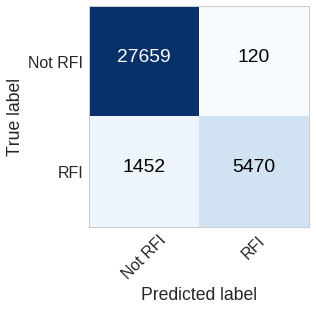

('Misclassification error rate:', 0.045)
('matthews_corrcoef: ', 0.8543086145380312)


In [33]:
conf_mat=confusion_matrix(y_test0,pred)
print conf_mat
plot_confusion_matrix(conf_mat, classes=target_names,normalize=False)
sns.plt.show()
print("Misclassification error rate:",round(np.mean(pred!=y_test0),3))
print("matthews_corrcoef: ",matthews_corrcoef(y_test0,pred))

In [34]:
nsimu = 21
accuracy=[0]*nsimu
ntree = [0]*nsimu
for i in range(1,nsimu):
    rfc = RandomForestClassifier(n_estimators=i*5,min_samples_split=10,max_depth=None,criterion='gini')
    rfc.fit(x_train0, y_train0)
    pred = rfc.predict(x_test0)
    cm = confusion_matrix(y_test0,pred)
    accuracy[i] = (cm[0,0]+cm[1,1])/float(cm.sum())
    ntree[i]=i*5

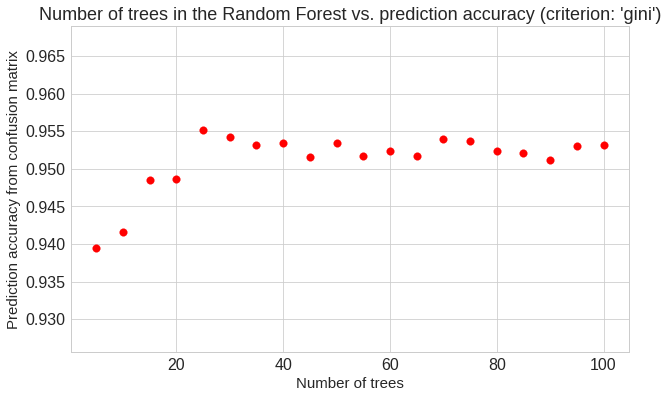

In [35]:
sns.plt.figure(figsize=(10,6))
sns.plt.scatter(x=ntree[1:nsimu],y=accuracy[1:nsimu],s=60,c='red')
sns.plt.title("Number of trees in the Random Forest vs. prediction accuracy (criterion: 'gini')", fontsize=18)
sns.plt.xlabel("Number of trees", fontsize=15)
sns.plt.ylabel("Prediction accuracy from confusion matrix", fontsize=15)
sns.plt.show()

In [36]:
nsimu = 21
accuracy=[0]*nsimu
ntree = [0]*nsimu
for i in range(1,nsimu):
    rfc = RandomForestClassifier(n_estimators=i*5,min_samples_split=10,max_depth=None,criterion='entropy')
    rfc.fit(x_train0, y_train0)
    pred = rfc.predict(x_test0)
    cm = confusion_matrix(y_test0,pred)
    accuracy[i] = (cm[0,0]+cm[1,1])/float(cm.sum())
    ntree[i]=i*5

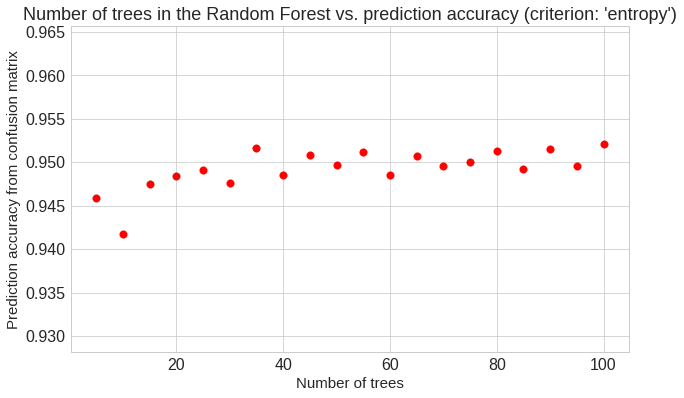

In [37]:
sns.plt.figure(figsize=(10,6))
sns.plt.scatter(x=ntree[1:nsimu],y=accuracy[1:nsimu],s=60,c='red')
sns.plt.title("Number of trees in the Random Forest vs. prediction accuracy (criterion: 'entropy')", fontsize=18)
sns.plt.xlabel("Number of trees", fontsize=15)
sns.plt.ylabel("Prediction accuracy from confusion matrix", fontsize=15)
sns.plt.show()

Fixing max tree depth

In [38]:
nsimu = 21
accuracy=[0]*nsimu
ntree = [0]*nsimu
for i in range(1,nsimu):
    rfc = RandomForestClassifier(n_estimators=i*5,min_samples_split=10,max_depth=None,criterion='gini')
    rfc.fit(x_train0, y_train0)
    pred = rfc.predict(x_test0)
    cm = confusion_matrix(y_test0,pred)
    accuracy[i] = float(cm[0,0]+cm[1,1])/cm.sum()
    ntree[i]=i*5

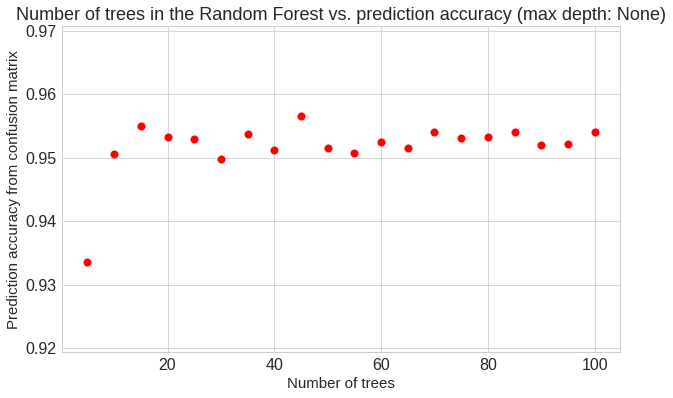

In [39]:
sns.plt.figure(figsize=(10,6))
sns.plt.scatter(x=ntree[1:nsimu],y=accuracy[1:nsimu],s=60,c='red')
sns.plt.title("Number of trees in the Random Forest vs. prediction accuracy (max depth: None)", fontsize=18)
sns.plt.xlabel("Number of trees", fontsize=15)
sns.plt.ylabel("Prediction accuracy from confusion matrix", fontsize=15)
sns.plt.show()

In [40]:
nsimu = 21
accuracy=[0]*nsimu
ntree = [0]*nsimu
for i in range(1,nsimu):
    rfc = RandomForestClassifier(n_estimators=i*5,min_samples_split=10,max_depth=5,criterion='gini')
    rfc.fit(x_train0, y_train0)
    pred = rfc.predict(x_test0)
    cm = confusion_matrix(y_test0,pred)
    accuracy[i] = float(cm[0,0]+cm[1,1])/cm.sum()
    ntree[i]=i*5

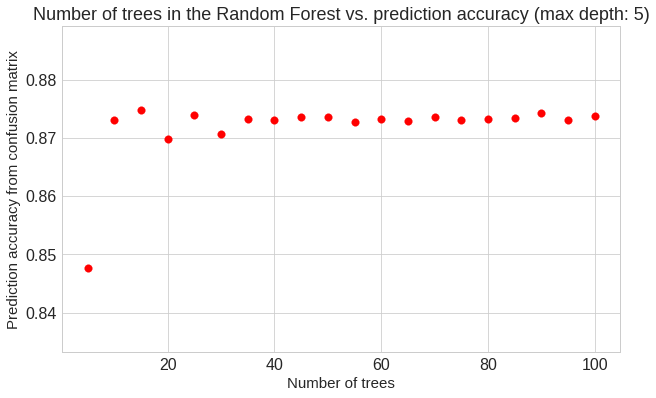

In [41]:
sns.plt.figure(figsize=(10,6))
sns.plt.scatter(x=ntree[1:nsimu],y=accuracy[1:nsimu],s=60,c='red')
sns.plt.title("Number of trees in the Random Forest vs. prediction accuracy (max depth: 5)", fontsize=18)
sns.plt.xlabel("Number of trees", fontsize=15)
sns.plt.ylabel("Prediction accuracy from confusion matrix", fontsize=15)
sns.plt.show()

Minimum sample split criteria

In [42]:
nsimu = 21
accuracy=[0]*nsimu
ntree = [0]*nsimu
for i in range(1,nsimu):
    rfc = RandomForestClassifier(n_estimators=i*5,min_samples_split=2,max_depth=None,criterion='gini')
    rfc.fit(x_train0, y_train0)
    pred = rfc.predict(x_test0)
    cm = confusion_matrix(y_test0,pred)
    accuracy[i] = float(cm[0,0]+cm[1,1])/cm.sum()
    ntree[i]=i*5

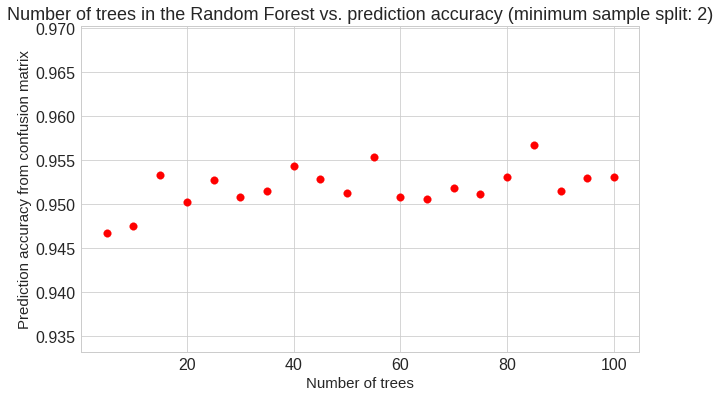

In [ ]:
sns.plt.figure(figsize=(10,6))
sns.plt.scatter(x=ntree[1:nsimu],y=accuracy[1:nsimu],s=60,c='red')
sns.plt.title("Number of trees in the Random Forest vs. prediction accuracy (minimum sample split: 2)", fontsize=18)
sns.plt.xlabel("Number of trees", fontsize=15)
sns.plt.ylabel("Prediction accuracy from confusion matrix", fontsize=15)
sns.plt.show()

In [ ]:
nsimu = 21
accuracy=[0]*nsimu
ntree = [0]*nsimu
for i in range(1,nsimu):
    rfc = RandomForestClassifier(n_estimators=i*5,min_samples_split=20,max_depth=None,criterion='gini')
    rfc.fit(x_train0, y_train0)
    pred = rfc.predict(x_test0)
    cm = confusion_matrix(y_test0,pred)
    accuracy[i] = float(cm[0,0]+cm[1,1])/cm.sum()
    ntree[i]=i*5

In [ ]:
sns.plt.figure(figsize=(10,6))
sns.plt.scatter(x=ntree[1:nsimu],y=accuracy[1:nsimu],s=60,c='red')
sns.plt.title("Number of trees in the Random Forest vs. prediction accuracy (minimum sample split: 20)", fontsize=18)
sns.plt.xlabel("Number of trees", fontsize=15)
sns.plt.ylabel("Prediction accuracy from confusion matrix", fontsize=15)
sns.plt.show()

In [ ]:
model_acy_rfc = []
model_acy_gnb = []
model_acy_knn = []
for i in range(50):
    if i % 10 == 0:
        print i,
    X0 = shuffle(X0)
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X0[names], X0['rfi'], train_size=0.7)
    
    decision_tree_classifier = RandomForestClassifier(n_jobs=-1,random_state=4)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_rfc.append(classifier_accuracy)
    
    decision_tree_classifier = GaussianNB()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_gnb.append(classifier_accuracy)
    
    decision_tree_classifier = KNeighborsClassifier(n_jobs=-1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_knn.append(classifier_accuracy)

del training_inputs
del testing_inputs
del training_classes
del testing_classes
del classifier_accuracy
del decision_tree_classifier

In [ ]:
sns.distplot(model_acy_rfc,label="RFC")
sns.distplot(model_acy_knn,label="KNN")
sns.distplot(model_acy_gnb, label="NB")
sns.plt.ylabel("Count")
sns.plt.xlabel("model accuracy")
sns.plt.legend(loc="best")
sns.plt.grid(True)
sns.plt.show()
print "RFC: Mean {0} \t std {1}".format(np.mean(model_acy_rfc),np.std(model_acy_rfc))
print "KNN: Mean {0} \t std {1}".format(np.mean(model_acy_knn),np.std(model_acy_knn))
print "NB:  Mean {0} \t std {1}".format(np.mean(model_acy_gnb),np.std(model_acy_gnb))


In [ ]:
cv = StratifiedKFold(y=y_train0,shuffle=True,n_folds=10,random_state=0)

gnb = GaussianNB()

rfc = RandomForestClassifier(random_state=4)
grid = {'n_estimators': np.arange(1, 50)
        ,'criterion': ['gini', 'entropy']
        ,'max_features':['sqrt','log2']
        ,'max_depth':np.arange(1,50)
        ,'min_samples_split':np.arange(1,50)}
rfc = RandomizedSearchCV(rfc, grid, cv=cv,n_iter=30,random_state=10004,)

knn = KNeighborsClassifier()
grid = {"n_neighbors": np.arange(1, 50, 2)
        ,"metric": ["euclidean", "minkowski"]}
knn = RandomizedSearchCV(knn, grid, cv=cv,n_iter=30,random_state=10004)

In [ ]:
gnb.fit(x_train0,y_train0)

In [ ]:
rfc.fit(x_train0,y_train0)

In [ ]:
knn.fit(x_train0,y_train0)

In [ ]:
y_pred_prob_gnb = gnb.predict_proba(x_test0)
y_pred_prob_rfc = rfc.predict_proba(x_test0)
y_pred_prob_knn = knn.predict_proba(x_test0)
y_pred_gnb = gnb.predict(x_test0)
y_pred_rfc = rfc.predict(x_test0)
y_pred_knn = knn.predict(x_test0)

In [ ]:
report(rfc.cv_results_,"RFC")

In [ ]:
report(knn.cv_results_,"KNN")

In [ ]:
rfc=rfc.best_estimator_
knn=knn.best_estimator_

In [ ]:
model_names =['RFC','KNN','NB']
roc_plot([y_pred_prob_rfc,y_pred_prob_knn,y_pred_prob_gnb],False,model_names)
sns.plt.grid(True)
sns.plt.show()

In [ ]:
sns.plt.figure()
plot_learning_curves(x_train0.values, y_train0.values, x_test0.values, y_test0.values, rfc
                     ,print_model=False,style="seaborn-whitegrid")
sns.plt.title('RFC Model')
sns.plt.show()

In [ ]:
sns.plt.figure()
plot_learning_curves(x_train0.values, y_train0.values, x_test0.values, y_test0.values, knn
                     ,print_model=False,style="seaborn-whitegrid")
sns.plt.title('KNN Model')
sns.plt.show()

In [ ]:
sns.plt.figure()
plot_learning_curves(x_train0.values, y_train0.values, x_test0.values, y_test0.values, gnb
                     ,print_model=False,style="seaborn-whitegrid")
sns.plt.title('NB Model')

sns.plt.show()

In [ ]:
evaluate(y_pred_rfc,'RFC')
conf_mat=confusion_matrix(y_test0,y_pred_rfc)
print conf_mat
plot_confusion_matrix(conf_mat, classes=target_names,normalize=False)
sns.plt.show()
print("Misclassification error rate:",round(np.mean(y_pred_rfc!=y_test0),3))
print("matthews_corrcoef: ",matthews_corrcoef(y_test0,y_pred_rfc))
sns.plt.figure()
sns.plt.scatter(x_test0[names[1]],x_test0[names[2]],c='k',alpha=0.5,label='correct-labels')
sns.plt.scatter(x_test0[names[1]].values[np.where(y_test0!=y_pred_rfc)[0]],x_test0[names[2]].values[np.where(y_test0!=y_pred_rfc)[0]],c='r',label='miss-labels')
sns.plt.xlabel(names[1])
sns.plt.ylabel(names[2])
sns.plt.legend(loc='best')
sns.plt.show()

In [ ]:
evaluate(y_pred_knn,'KNN')
conf_mat=confusion_matrix(y_test0,y_pred_knn)
print conf_mat
plot_confusion_matrix(conf_mat, classes=target_names,normalize=False)
sns.plt.show()
print("Misclassification error rate:",round(np.mean(y_pred_knn!=y_test0),3))
print("matthews_corrcoef: ",matthews_corrcoef(y_test0,y_pred_knn))
sns.plt.figure()
sns.plt.scatter(x_test0[names[1]],x_test0[names[2]],c='k',alpha=0.5,label='correct-labels')
sns.plt.scatter(x_test0[names[1]].values[np.where(y_test0!=y_pred_knn)[0]],x_test0[names[2]].values[np.where(y_test0!=y_pred_knn)[0]],c='r',label='miss-labels')
sns.plt.xlabel(names[1])
sns.plt.ylabel(names[2])
sns.plt.legend(loc='best')
sns.plt.show()

In [ ]:
evaluate(y_pred_gnb,'NB')
conf_mat=confusion_matrix(y_test0,y_pred_gnb)
print conf_mat
plot_confusion_matrix(conf_mat, classes=target_names,normalize=False)
sns.plt.show()
print("Misclassification error rate:",round(np.mean(y_pred_gnb!=y_test0),3))
print("matthews_corrcoef: ",matthews_corrcoef(y_test0,y_pred_gnb))
sns.plt.figure()
sns.plt.scatter(x_test0[names[1]],x_test0[names[2]],c='k',alpha=0.5,label='correct-labels')
sns.plt.scatter(x_test0[names[1]].values[np.where(y_test0!=y_pred_gnb)[0]],x_test0[names[2]].values[np.where(y_test0!=y_pred_gnb)[0]],c='r',label='miss-labels')
sns.plt.xlabel(names[1])
sns.plt.ylabel(names[2])
sns.plt.legend(loc='best')
sns.plt.show()

In [ ]:
testVV = pd.DataFrame.from_csv('HH1333134985_pks1613-586.1822.ms_all_data_baseline0and1.csv')
#testVV = testVV.replace(to_replace=np.nan,value=0.0)
rfi_rfc =rfc.predict(testVV[names])
rfi_knn = knn.predict(testVV[names])
rfi_gnb = gnb.predict(testVV[names])

image = np.reshape(testVV['d_p'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F' )
org_flags = np.reshape(testVV['rfi'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F')
rfc_flags = np.reshape(rfi_rfc,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F')
knn_flags = np.reshape(rfi_knn,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F')
gnb_flags = np.reshape(rfi_gnb,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F')


sns.plt.figure(figsize=(20,20))
sns.plt.subplot(5,1,1)
sns.plt.imshow(image,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("No flags")
sns.plt.xticks([])
sns.plt.yticks([])

sns.plt.subplot(5,1,2)
sns.plt.imshow(np.ma.array(image,mask=org_flags),cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Human flags")
sns.plt.xticks([])
sns.plt.yticks([])


sns.plt.subplot(5,1,3)
sns.plt.imshow(np.ma.array(image,mask=rfc_flags),cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Time")
#sns.plt.xlabel("Channels")
sns.plt.ylabel("RFC \n Time")
sns.plt.xticks([])


sns.plt.subplot(5,1,4)
sns.plt.imshow(np.ma.array(image,mask=knn_flags),cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("KNN")
sns.plt.xticks([])
sns.plt.yticks([])

sns.plt.subplot(5,1,5)
sns.plt.imshow(np.ma.array(image,mask=gnb_flags),cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
sns.plt.xlabel("Channels")
sns.plt.ylabel("NB")
sns.plt.yticks([])
sns.plt.savefig("Results/HH/seen_HH-model_flags2.png",dpi=600)
sns.plt.show()

In [ ]:
MSfile ='1333134985/pks1613-586.1822.ms/'
t = table(MSfile)
A1 = t.getcol("ANTENNA1")
A2 = t.getcol("ANTENNA2")
ant_list = list(set(np.append(A1,A2)))
nants = len(ant_list)
flags = t.getcol("FLAG")
ant1 = 0
ant2 = 1
poln = 0
flag_mask = np.array(flags[(A1==ant1) & (A2==ant2)][:,200:800,poln])
sns.plt.figure(figsize=(20,20))
sns.plt.subplot(3,1,1)
sns.plt.imshow(np.ma.array(image,mask=flag_mask),cmap=palette,aspect ='auto')
sns.plt.subplot(3,1,2)
sns.plt.imshow(np.ma.array(image,mask=org_flags),cmap=palette,aspect ='auto')
sns.plt.subplot(3,1,3)
sns.plt.imshow(np.ma.array(image,mask=rfc_flags),cmap=palette,aspect ='auto')

sns.plt.show()

In [ ]:
org_flags = org_flags.flatten()
rfc_flags = rfc_flags.flatten()
flag_mask = flag_mask.flatten()

$$MCC = \frac{\text{TP * TN - FP * FN} }{\sqrt{\text{(TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)}}}$$

In [ ]:
def mcc(org_ao):
    tn, fp, fn, tp = org_ao.ravel()
    up = np.float64( (tp*tn) - (fp*fn)  )
    bottom = np.sqrt(np.float64( np.float64(tp+fp) * np.float64(tp+fn) * np.float64(tn+fp) * np.float64(tn+fn) ))
    return up/bottom

In [ ]:
print np.sum(org_flags)/(655.0*600)
print np.sum(flag_mask)/(655.0*600)
print np.sum(rfc_flags)/(655.0*600)
org_rfc = mcc(confusion_matrix(org_flags,rfc_flags))
org_ao = mcc(confusion_matrix(org_flags,flag_mask))
org_org = mcc(confusion_matrix(org_flags,org_flags))
print org_rfc
print org_ao
print org_org

In [ ]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_space= []
# Print the feature ranking
impdf = []
for f in range(x_train0.shape[1]):
    feature_space.append(names[indices[f]])
    impdf.append({'features': names[indices[f]], 'importance': importances[indices[f]]})

impdf = pd.DataFrame(impdf)
impdf = impdf.sort_values(by='importance', ascending=False).reset_index(drop=True)
impdf['importance'] /= impdf['importance'].sum()
impdf.index = impdf['features']
sns.plt.figure()
impdf.plot(kind='bar', title='Importance Features', figsize=(20, 8),legend=False,fontsize=16.0)
sns.plt.ylabel("Measure of Importance")
sns.plt.grid(True)
sns.plt.show()
impdf = impdf.sort('importance')

In [ ]:
sns.plt.figure()
sns.plt.scatter(x_test0[names[1]],x_test0[names[2]],c='k',alpha=0.5,label='correct-labels')
sns.plt.scatter(x_test0[names[1]].values[np.where(y_test0!=y_pred_rfc)[0]],x_test0[names[2]].values[np.where(y_test0!=y_pred_rfc)[0]],c='r',label='miss-labels')
sns.plt.xlabel(names[1])
sns.plt.ylabel(names[2])
sns.plt.legend(loc='best')
sns.plt.show()

In [ ]:
impdf[-6:]['features'].values

In [ ]:
model_acy_rfc = []
model_acy_gnb = []
model_acy_knn = []
for i in range(100):
    if i % 10 == 0:
        print i,
    X0 = shuffle(X0)
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X0[impdf[-6:]['features'].values], X0['rfi'], train_size=0.7)
    
    decision_tree_classifier = RandomForestClassifier(n_jobs=-1,random_state=4)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_rfc.append(classifier_accuracy)
    
    decision_tree_classifier = GaussianNB()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_gnb.append(classifier_accuracy)
    
    decision_tree_classifier = KNeighborsClassifier(n_jobs=-1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_knn.append(classifier_accuracy)

del training_inputs
del testing_inputs
del training_classes
del testing_classes
del classifier_accuracy
del decision_tree_classifier

In [ ]:
sns.distplot(model_acy_rfc,label="RFC")
sns.distplot(model_acy_knn,label="KNN")
sns.distplot(model_acy_gnb, label="NB")
sns.plt.ylabel("Count")
sns.plt.xlabel("model accuracy")
sns.plt.legend(loc="best")
sns.plt.grid(True)
sns.plt.show()
print "RFC: Mean {0} \t std {1}".format(np.mean(model_acy_rfc),np.std(model_acy_rfc))
print "KNN: Mean {0} \t std {1}".format(np.mean(model_acy_knn),np.std(model_acy_knn))
print "NB:  Mean {0} \t std {1}".format(np.mean(model_acy_gnb),np.std(model_acy_gnb))

In [ ]:
impdf[-3:]['features'].values

In [ ]:
model_acy_rfc = []
model_acy_gnb = []
model_acy_knn = []
for i in range(100):
    if i % 10 == 0:
        print i,
    X0 = shuffle(X0)
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X0[impdf[-3:]['features'].values], X0['rfi'], train_size=0.7)
    
    decision_tree_classifier = RandomForestClassifier(n_jobs=-1,random_state=4)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_rfc.append(classifier_accuracy)
    
    decision_tree_classifier = GaussianNB()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_gnb.append(classifier_accuracy)
    
    decision_tree_classifier = KNeighborsClassifier(n_jobs=-1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_knn.append(classifier_accuracy)

del training_inputs
del testing_inputs
del training_classes
del testing_classes
del classifier_accuracy
del decision_tree_classifier

In [ ]:
sns.distplot(model_acy_rfc,label="RFC")
sns.distplot(model_acy_knn,label="KNN")
sns.distplot(model_acy_gnb, label="NB")
sns.plt.ylabel("Count")
sns.plt.xlabel("model accuracy")
sns.plt.legend(loc="best")
sns.plt.grid(True)
sns.plt.show()
print "RFC: Mean {0} \t std {1}".format(np.mean(model_acy_rfc),np.std(model_acy_rfc))
print "KNN: Mean {0} \t std {1}".format(np.mean(model_acy_knn),np.std(model_acy_knn))
print "NB:  Mean {0} \t std {1}".format(np.mean(model_acy_gnb),np.std(model_acy_gnb))

# feature Selection

In [ ]:
score = fisher_score.fisher_score(x_train0, y_train0)

In [ ]:
idx = fisher_score.feature_ranking(score)
print idx
print x_train0[idx[:5]].keys()
print impdf[-5:]['features'].values

In [ ]:
model_acy_rfc = []
model_acy_gnb = []
model_acy_knn = []
for i in range(100):
    if i % 10 == 0:
        print i,
    X0 = shuffle(X0)
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X0[idx[:5]], X0['rfi'], train_size=0.7)
    
    decision_tree_classifier = RandomForestClassifier(n_jobs=-1,random_state=4)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_rfc.append(classifier_accuracy)
    
    decision_tree_classifier = GaussianNB()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_gnb.append(classifier_accuracy)
    
    decision_tree_classifier = KNeighborsClassifier(n_jobs=-1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_knn.append(classifier_accuracy)

del training_inputs
del testing_inputs
del training_classes
del testing_classes
del classifier_accuracy
del decision_tree_classifier

In [ ]:
sns.distplot(model_acy_rfc,label="RFC")
sns.distplot(model_acy_knn,label="KNN")
sns.distplot(model_acy_gnb, label="NB")
sns.plt.ylabel("Count")
sns.plt.xlabel("model accuracy")
sns.plt.legend(loc="best")
sns.plt.grid(True)
sns.plt.show()
print "RFC: Mean {0} \t std {1}".format(np.mean(model_acy_rfc),np.std(model_acy_rfc))
print "KNN: Mean {0} \t std {1}".format(np.mean(model_acy_knn),np.std(model_acy_knn))
print "NB:  Mean {0} \t std {1}".format(np.mean(model_acy_gnb),np.std(model_acy_gnb))

In [ ]:
score = reliefF.reliefF(x_train0.values, y_train0.values)

In [ ]:
idx = reliefF.feature_ranking(score)
print idx
print x_train0[idx[:5]].keys()
print impdf[-6:]['features'].values

In [ ]:
model_acy_rfc = []
model_acy_gnb = []
model_acy_knn = []
for i in range(100):
    if i % 10 == 0:
        print i,
    X0 = shuffle(X0)
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X0[idx[:5]], X0['rfi'], train_size=0.7)
    
    decision_tree_classifier = RandomForestClassifier(n_jobs=-1,random_state=4)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_rfc.append(classifier_accuracy)
    
    decision_tree_classifier = GaussianNB()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_gnb.append(classifier_accuracy)
    
    decision_tree_classifier = KNeighborsClassifier(n_jobs=-1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_knn.append(classifier_accuracy)

del training_inputs
del testing_inputs
del training_classes
del testing_classes
del classifier_accuracy
del decision_tree_classifier

In [ ]:
sns.distplot(model_acy_rfc,label="RFC")
sns.distplot(model_acy_knn,label="KNN")
sns.distplot(model_acy_gnb, label="NB")
sns.plt.ylabel("Count")
sns.plt.xlabel("model accuracy")
sns.plt.legend(loc="best")
sns.plt.grid(True)
sns.plt.show()
print "RFC: Mean {0} \t std {1}".format(np.mean(model_acy_rfc),np.std(model_acy_rfc))
print "KNN: Mean {0} \t std {1}".format(np.mean(model_acy_knn),np.std(model_acy_knn))
print "NB:  Mean {0} \t std {1}".format(np.mean(model_acy_gnb),np.std(model_acy_gnb))

In [ ]:
idx = CFS.cfs(x_train0.values, y_train0.values)

In [ ]:
print idx
print x_train0[idx[:5]].keys()
print impdf[-5:]['features'].values

In [ ]:
model_acy_rfc = []
model_acy_gnb = []
model_acy_knn = []
for i in range(100):
    if i % 10 == 0:
        print i,
    X0 = shuffle(X0)
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X0[idx[:5]], X0['rfi'], train_size=0.7)
    
    decision_tree_classifier = RandomForestClassifier(n_jobs=-1,random_state=4)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_rfc.append(classifier_accuracy)
    
    decision_tree_classifier = GaussianNB()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_gnb.append(classifier_accuracy)
    
    decision_tree_classifier = KNeighborsClassifier(n_jobs=-1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_knn.append(classifier_accuracy)

del training_inputs
del testing_inputs
del training_classes
del testing_classes
del classifier_accuracy
del decision_tree_classifier

In [ ]:
sns.distplot(model_acy_rfc,label="RFC")
sns.distplot(model_acy_knn,label="KNN")
sns.distplot(model_acy_gnb, label="NB")
sns.plt.ylabel("Count")
sns.plt.xlabel("model accuracy")
sns.plt.legend(loc="best")
sns.plt.grid(True)
sns.plt.show()
print "RFC: Mean {0} \t std {1}".format(np.mean(model_acy_rfc),np.std(model_acy_rfc))
print "KNN: Mean {0} \t std {1}".format(np.mean(model_acy_knn),np.std(model_acy_knn))
print "NB:  Mean {0} \t std {1}".format(np.mean(model_acy_gnb),np.std(model_acy_gnb))

## Conclusion

To conclude on can see that the random forest classifier performs better than the KNN and the NB on all fronts.
One can see that all the features selection techniques that have been been used show that the feature importance obtained from the RFC show a better selection of the features than all the other features selection techniques used and as seen above the none of the selected features show any signs of overfitting. Moving forward the RFC is the best classifier to use for RFI detection.